Dataset Overview:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Optimized Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.78      0.84        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



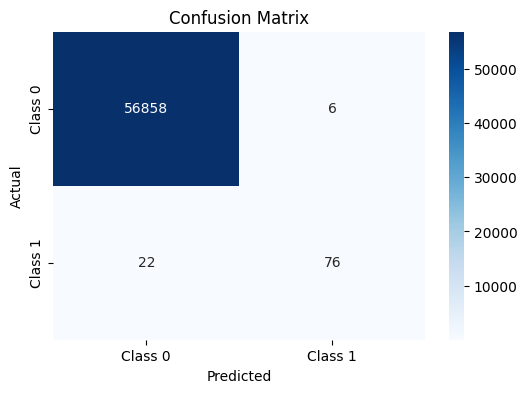

Confusion Matrix:
 [[56858     6]
 [   22    76]]
Accuracy Score: 0.9995084442259752
F1 Score: 0.8444444444444444


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split
from sklearn.model_selection import train_test_split

# XGBoost Classifier
from xgboost import XGBClassifier

# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_curve

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# Load CSV dataset
df = pd.read_csv('creditcard.csv')

# Display dataset info
print("Dataset Overview:")
print(df.head())

# Define feature columns and target column
target_column = 'Class'
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target

# Check class distribution
print("\nClass distribution before balancing:")
print(y.value_counts())

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE with lower sampling to avoid excessive duplication
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Optimized XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=200,            # Increase trees
    learning_rate=0.05,          # Lower learning rate
    max_depth=6,                 # Optimal depth for preventing overfitting
    scale_pos_weight=5,          # Adjust for class imbalance
    subsample=0.8,               # Reduce overfitting
    colsample_bytree=0.8,        # Feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions with threshold tuning
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Get probability scores

# Find best threshold using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]  # Max F1-score threshold

y_pred_adjusted = (y_pred_proba > best_threshold).astype(int)

# Model evaluation
print("\nOptimized Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print final scores
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("Accuracy Score:", accuracy_score(y_test, y_pred_adjusted))
print("F1 Score:", f1_score(y_test, y_pred_adjusted))
